> Apply Naive Bayes to predict if users are likely to click into ad based on input features (impression, ad position, keywords, title, description, etc.)

In [31]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [32]:
data = fetch_openml(data_id=1220)

X = pd.DataFrame(data['data'], columns=data['feature_names']).astype(float)
y = pd.Series(data['target']).astype(int)

In [33]:
X.head()

,impression,ad_id,advertiser_id,depth,position,keyword_id,title_id,description_id,user_id
0,1.0,8343295.0,11700.0,3.0,3.0,21264.0,27892.0,1559.0,0.0
1,1.0,20017077.0,23798.0,1.0,1.0,35498.0,4.0,36476.0,562934.0
2,1.0,21348354.0,36654.0,1.0,1.0,19975.0,36105.0,33292.0,11621116.0
3,1.0,20366086.0,33280.0,3.0,3.0,5942.0,4057.0,4390.0,8778348.0
4,1.0,6803526.0,10790.0,2.0,1.0,60593.0,25242.0,1679.0,12118311.0


In [34]:
y.head()

0    0
1    1
2    0
3    0
4    0
Name: click, dtype: int64

In [35]:
y.value_counts()

click
0    33220
1     6728
Name: count, dtype: int64

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
model = GaussianNB()
model.fit(X_train, y_train)

,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [38]:
model.score(X_train, y_train)

0.8086512466206068

In [39]:
model.score(X_test, y_test)

0.8078502052668469

In [40]:
y_pred = model.predict(X_test)

In [41]:
print("Accuracy is ", accuracy_score(y_test, y_pred)*100, "%")

Accuracy is  80.78502052668469 %


In [42]:
confusion_matrix(y_test, y_pred)

array([[7992,  313],
       [1606,   76]])

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      8305
           1       0.20      0.05      0.07      1682

    accuracy                           0.81      9987
   macro avg       0.51      0.50      0.48      9987
weighted avg       0.73      0.81      0.75      9987



In [44]:
y_prob = model.predict_log_proba(X_test)
y_prob

array([[-0.09476505, -2.40336297],
       [-0.11668394, -2.20606112],
       [-0.15932881, -1.91539209],
       ...,
       [-0.12053168, -2.17550326],
       [-0.09552868, -2.39571292],
       [-0.26736744, -1.44983831]], shape=(9987, 2))

In [45]:
roc_auc_score(y_test, y_prob[:, 1])

0.549416529875775

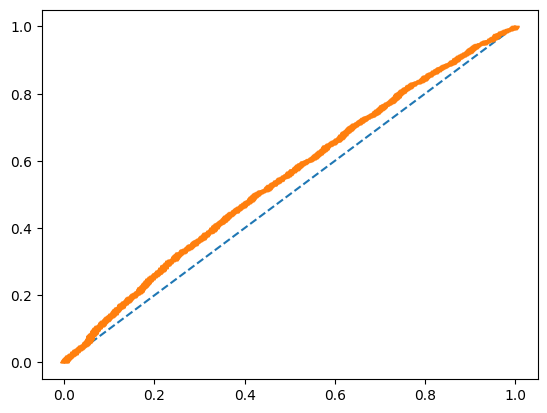

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])

plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='_')
plt.show()

> The model is failed to identify Class 1:
> + Recall at 5%: The model only catches 5% of the actual Class 1 cases. It is missing 95% of the positive instances.
> + Precision at 20%: Even when it does predict Class 1, it’s only right 20% of the time.
> + F1-Score at 7%: This near-zero score confirms that the model has no predictive power for the minority class.

##### Resampling data

In [47]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

In [48]:
unique_elements, counts_elements = np.unique(y_resampled, return_counts=True)
print('Frequency of each category:')
print(np.asarray((unique_elements, counts_elements)))

Frequency of each category:
[[   0    1]
 [6728 6728]]


In [49]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

In [50]:
model_r = GaussianNB()
model_r.fit(X_train_r, y_train_r)

,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [51]:
y_pred_r = model.predict(X_test_r)

In [52]:
confusion_matrix(y_test_r, y_pred_r)

array([[1642,   59],
       [1596,   67]])

In [53]:
print(classification_report(y_test_r, y_pred_r))

              precision    recall  f1-score   support

           0       0.51      0.97      0.66      1701
           1       0.53      0.04      0.07      1663

    accuracy                           0.51      3364
   macro avg       0.52      0.50      0.37      3364
weighted avg       0.52      0.51      0.37      3364



In [54]:
y_prob_r = model.predict_proba(X_test_r)
y_prob_r

array([[9.08794901e-01, 9.12050989e-02],
       [9.10578135e-01, 8.94218651e-02],
       [9.50145867e-09, 9.99999990e-01],
       ...,
       [9.09844993e-01, 9.01550069e-02],
       [1.64622602e-02, 9.83537740e-01],
       [8.89335875e-01, 1.10664125e-01]], shape=(3364, 2))

In [55]:
roc_auc_score(y_test_r, y_prob_r[:,1])

0.5569305381893075

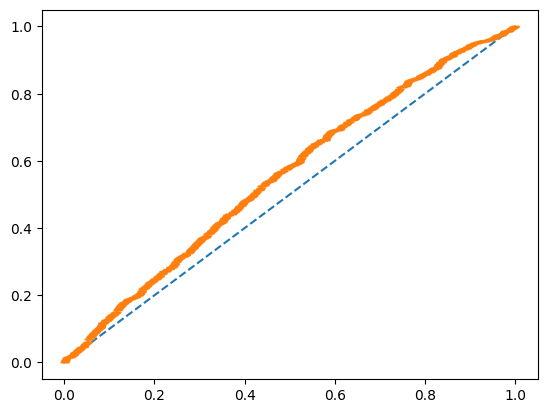

In [56]:
fpr, tpr, thresholds = roc_curve(y_test_r, y_prob_r[:, 1])

plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='_')
plt.show()

> Performance don't improve even when doing resampling => Consider to use another model.

In [57]:
import pickle

pkl_filename = "exercise_1__click_prediction__predict_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [58]:
with open(pkl_filename, 'rb') as file:
    click_model = pickle.load(file)

In [59]:
X_train

,impression,ad_id,advertiser_id,depth,position,keyword_id,title_id,description_id,user_id
33083,1.0,20163594.0,27961.0,2.0,1.0,2904.0,4987.0,5849.0,0.0
23156,1.0,4381909.0,21500.0,3.0,2.0,5544.0,20759.0,19958.0,1114612.0
4399,1.0,20054444.0,16945.0,3.0,2.0,271.0,233681.0,195394.0,6886472.0
34378,1.0,4411221.0,2617.0,2.0,2.0,8878.0,65667.0,59098.0,0.0
38144,1.0,20030149.0,23799.0,3.0,3.0,412.0,15.0,19.0,5145029.0
...,...,...,...,...,...,...,...,...,...
6265,1.0,21273771.0,36438.0,2.0,1.0,2389.0,5157.0,5481.0,6019594.0
11284,1.0,7832015.0,25334.0,3.0,1.0,78621.0,124206.0,104985.0,0.0
38158,1.0,10950992.0,1268.0,2.0,1.0,79123.0,113816.0,2.0,14727588.0
860,4.0,5146454.0,27486.0,2.0,2.0,27551.0,11845.0,13294.0,131610.0


In [60]:
X_test = [[100000, 242, 4343, 30, 1000, 2425, 5484, 578339, 24354]
          , [1, 242, 4343, 30, 1000, 2425, 5484, 578339, 24354]]
y_pred = click_model.predict(X_test)
y_pred

array([1, 0])